In [78]:
import re
import random
import pandas as pd
import hashlib

In [79]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [80]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,66.127548,13.225510,17.225284,5
CCH Tax Forms Project,106.704872,5.081184,9.227989,21
OAuth 2.0 RFC6749,156.356432,14.214221,19.462584,11
Azure DevOps Pipelines,186.814824,93.407412,97.407395,2
Active Directory and Azure Files,199.486545,5.391528,13.850595,37
pfSense,212.061672,17.671806,26.923278,12
Accounting,250.675557,14.745621,21.870811,17
"The Starless Crown, Rollins",362.338881,13.419959,21.608829,27
Python + Oauth2.0,604.035866,26.262429,40.187207,23
Azure Files Documentation,784.685529,24.521423,45.184347,32


# Histogram

sum of ages: ~54272.86


<Axes: >

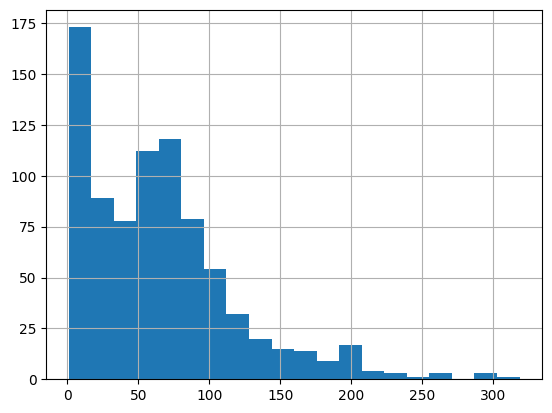

In [81]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54272.86


<Axes: >

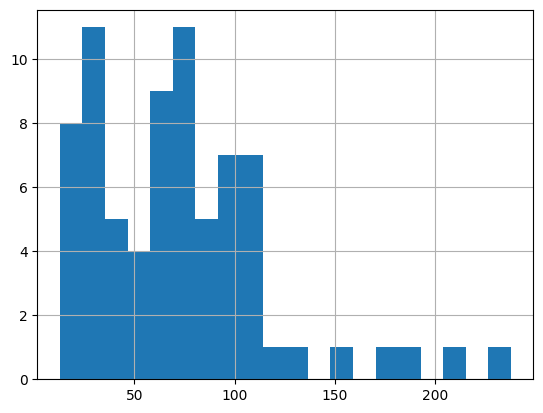

In [82]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [83]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [84]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [85]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 825
Total card age: 54272.86


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
93,JavaScript Concepts,Middleware: Functions in frameworks like Expre...,4a4154d0bb96cb5e884e43746f817099,-237.689039,72.669892,237.689039,-5377.572012,0.037482,74,0,0
96,JavaScript Concepts,Template Literals: Enhanced string syntax usin...,29bfc6f5c3a67f9c93819ab4e7625405,-175.844405,72.669892,237.689039,-5377.572012,0.037482,74,3,0
201,JavaScript Concepts,Ensure to use the comparison operator === inst...,297dae766c63de9c6e3fdb5c7f479a63,-114.131654,72.669892,237.689039,-5377.572012,0.037482,74,6,0
297,JavaScript Concepts,Callback functions are functions passed as arg...,6e6f8c21dac86de04ee128ad12ec6cda,-111.022185,72.669892,237.689039,-5377.572012,0.037482,74,9,0
299,JavaScript Concepts,Prototype-Based Inheritance: JavaScript uses p...,1ca5c051da5bd361c1428ac569cffd50,-103.713400,72.669892,237.689039,-5377.572012,0.037482,74,12,0
385,JavaScript Concepts,JavaScript's array destructuring syntax is a c...,d1873d9f239196132e5ff5341adb3922,-99.059338,72.669892,237.689039,-5377.572012,0.037482,74,15,0
464,JavaScript Concepts,Array slice Function: The slice method returns...,c46c6b6e8ee659e701bafd69ca2c9c31,-95.096206,72.669892,237.689039,-5377.572012,0.037482,74,18,0
530,JavaScript Concepts,Front: How do you create multiline strings usi...,0576807b2b6955c94c9c49ed2cf9a6b8,-90.532327,72.669892,237.689039,-5377.572012,0.037482,74,21,0
532,JavaScript Concepts,Prototype-Based Inheritance: JavaScript uses p...,15c51f22d63b1cbdb5bbdf67f20e7d12,-83.811915,72.669892,237.689039,-5377.572012,0.037482,74,24,0
591,JavaScript Concepts,Case Sensitivity: JavaScript identifiers are c...,a690de820e3447b985d4b49cc7bfe9a5,-79.119960,72.669892,237.689039,-5377.572012,0.037482,74,27,0


## Age Mean

In [86]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [87]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [88]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [89]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [90]:
existing_cards.head(10)['age'].sum()

np.float64(-1190.0204282611544)

In [91]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
21,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,-318.418865,107.368791,318.418865,-1932.638232,0.716235,18,0,0
97,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,-298.560529,60.867794,298.560529,-4686.820115,0.009487,77,0,0
81,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,-298.557467,98.398482,298.557467,-4821.525599,0.904107,49,0,0
45,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,-297.640769,106.770571,297.640769,-2989.575980,0.013401,28,0,0
73,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,-268.263226,102.309964,268.263226,-3887.778648,0.830309,38,0,0
65,VMWare,Type 1 Hypervisor\n\nA hypervisor that runs di...,69a3327d36d550a31995e37ddee2031e,-258.583543,111.330317,258.583543,-4119.221713,0.962398,37,0,0
74,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,-255.959291,102.309964,268.263226,-3887.778648,0.830309,38,1,1
46,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,-254.778748,106.770571,297.640769,-2989.575980,0.013401,28,1,1
93,JavaScript Concepts,Middleware: Functions in frameworks like Expre...,4a4154d0bb96cb5e884e43746f817099,-237.689039,72.669892,237.689039,-5377.572012,0.037482,74,0,0
98,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,-235.301223,60.867794,298.560529,-4686.820115,0.009487,77,1,1


In [92]:
existing_cards['age'].mean()

np.float64(-65.78528972134234)